In [73]:
import tensorflow as ts
import tensorflow.keras
from tensorflow.keras.datasets import mnist

#Loading the data into train and test sets

In [74]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## The data is 28x28 pixel handwriting digits images (0 - 9)

In [75]:
print(f'X Train shape: {x_train.shape} \n ')

print(f'X Test shape: {x_test.shape} \n ')


X Train shape: (60000, 28, 28) 
 
X Test shape: (10000, 28, 28) 
 


## Flattening  the image to a 1x784 vector

In [76]:
image_vector_size = 28*28
x_train = x_train.reshape(x_train.shape[0], image_vector_size)
x_test = x_test.reshape(x_test.shape[0], image_vector_size)

##Making the lables from numrical to a categorical ones (good for cost functuon and tranig)

In [77]:
from tensorflow.keras.utils import to_categorical
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [78]:
pip install scikeras 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential # Basic model wich on top of we'll add layares 
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout # A danse layer obcjet that we add to Sequential model
from scikeras.wrappers import KerasClassifier 

##Building a model and tuning it's hyperparameters as folow:
####1. Build a genral model functuon "model_generator" 
####2. Add layer/s with pramas as var with the ".add()" method
####3. Build a GridSearchCV/Random object and pass it the params
####4. Fit the data(traind) with .fit() method.
####5. Check the scores 

In [80]:
import random
import itertools
import time
from keras.callbacks import EarlyStopping
def model_generator(neurons,activation,optimizer,dropout_rate,norm=False,regularization=False):
  model = Sequential()
  if norm:
    if regularization:
      for i in range(len(neurons)):
        model.add(Dense(neurons[i],activation=activation[0]))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    else:
        for i in range(len(neurons)):
          model.add(Dense(neurons[i],activation=activation[0]))
          model.add(BatchNormalization())
  elif regularization:
        for i in range(len(neurons)):
          model.add(Dense(neurons[i],activation=activation[0]))
          model.add(Dropout(dropout_rate))
  else:
    for i in range(len(neurons)):
 
      model.add(Dense(neurons[i],activation=activation[0]))

  model.add(Dense(10,activation=activation[1]))
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
  return model

def MyRandomSearchCV(neurons: list,activation:list,optimizer:list,norm=False,regularization=False,epochs=30,batch_size=100,dropout_rate=0.2,early_stop=False,model=False):
    random_indexs_neutrons = tuple(set([random.randint(0,len(neurons) -1 ) for i in range(int(len(neurons) * 0.1 + 1))]))
    random_indexs_activation = tuple(set([random.randint(0,len(activation) - 1) for i in range(int(len(activation) * 0.1 + 1))]))
    random_indexs_optimizer = tuple(set([random.randint(0,len(optimizer) - 1) for i in range(int(len(optimizer) * 0.1 + 1))]))
    list_of_list = [random_indexs_neutrons,random_indexs_activation,random_indexs_optimizer]
    all_combintation = tuple((itertools.product(*list_of_list)))
    accuracy_map = {}
    model_map = {}
    for combination in all_combintation:
    
      neurons_index,activation_index,optimizer_index = combination
      model = model_generator(neurons=neurons[neurons_index],
                              activation=activation[activation_index],optimizer=optimizer[optimizer_index],
                              norm=norm,regularization=regularization,dropout_rate=dropout_rate)
      if early_stop:
        es = EarlyStopping(monitor='val_loss', mode='min',patience=1, verbose=1)
        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=True,callbacks=[es])
      else:
        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=False)
      loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
      key = (tuple(neurons[neurons_index]),tuple(activation[activation_index]),optimizer[optimizer_index])
      model_map[key] = {'accuracy' : accuracy,'loss' : loss, 'model':model}
      
    return model_map


## Adam v.s SGD

In [81]:
import time
T = time.time()
adam_ac = 0
num_of_iter = 1 
neurons = [(60,30,15)]
activations = [('relu','sigmoid')]
optimizer_adam = ['adam']
optimizer_sgd = ['sgd']

for i in range(num_of_iter):
  adam_ac += MyRandomSearchCV(neurons,activations,optimizer_adam)[(neurons[0],activations[0],optimizer_adam[0])]['accuracy']
print(f'Adam\'s AVG traning time is {(time.time() - T)/num_of_iter}\n')
print(f'Adam\'s AVG accuracy is {adam_ac/num_of_iter}\n')
T = time.time()
sgd_ac = 0
for i in range(num_of_iter):
  sgd_ac +=  MyRandomSearchCV(neurons,activations,optimizer_sgd)[(neurons[0],activations[0],optimizer_sgd[0])]['accuracy']
print(f'SGD\'sAVG traning time is {(time.time() - T)/num_of_iter}\n')
print(f'SGD\'s AVG accuracy is {sgd_ac/num_of_iter}\n')

Adam's AVG traning time is 83.43571901321411

Adam's AVG accuracy is 0.9646999835968018

SGD'sAVG traning time is 37.540167570114136

SGD's AVG accuracy is 0.20010000467300415



## Now let's use batch normalization

In [82]:
T = time.time()
norm_ac = 0
num_of_iter = 1
for i in range(num_of_iter):
  norm_ac += MyRandomSearchCV(neurons,activations,optimizer_adam ,norm=True)[(neurons[0],activations[0],optimizer_adam[0])]['accuracy']
print(f'Adam\'s AVG traning time is {(time.time() - T)/num_of_iter}\n')
print(f'Adam\'s AVG accuracy is {(norm_ac)/num_of_iter}\n')



Adam's AVG traning time is 83.65566682815552

Adam's AVG accuracy is 0.9740999937057495



## Now let's Add dropout regularization with norm 

In [83]:
T = time.time()
reg_ac = 0
num_of_iter = 1
for i in range(num_of_iter):
  reg_ac += MyRandomSearchCV(neurons,activations,optimizer_adam,norm=True,regularization=True)[(neurons[0],activations[0],optimizer_adam[0])]['accuracy']
print(f'Adam\'s AVG traning time is {(time.time() - T)/num_of_iter}\n')
print(f'Adam\'s AVG accuracy is {(reg_ac)/num_of_iter}\n')

Adam's AVG traning time is 54.23861765861511

Adam's AVG accuracy is 0.9751999974250793



## Only regularization

In [84]:
T = time.time()
reg_ac1 = 0
num_of_iter = 1
neurons = [(90,60,30,15)]
for i in range(num_of_iter):
  reg_ac1 += MyRandomSearchCV(neurons,activations,optimizer_adam,regularization=True,dropout_rate=0.25)[(neurons[0],activations[0],optimizer_adam[0])]['accuracy']
print(f'Adam\'s AVG traning time is {(time.time() - T)/num_of_iter}\n')
print(f'Adam\'s AVG accuracy is {(reg_ac1)/num_of_iter}\n')

Adam's AVG traning time is 42.67163372039795

Adam's AVG accuracy is 0.9430999755859375



##Early stopage
####Want to see when the acuurcy is not changing significantly and stop

In [85]:
from keras.callbacks import EarlyStopping
T = time.time()
num_of_iter = 1
accuracy = 0
neurons = [(60,30,15)]
for i in range(num_of_iter):
 res = MyRandomSearchCV(neurons,activations,optimizer_adam,early_stop=True)[(neurons[0],activations[0],optimizer_adam[0])]
 accuracy += res['accuracy']
 model = res['model']
print(f"Accuracy = {accuracy/num_of_iter}")
print(f"Time = {time.time() - T}")

Epoch 1/30
540/540 [==============================] - 2s 3ms/step - loss: 2.1077 - accuracy: 0.4141 - val_loss: 1.2133 - val_accuracy: 0.5520
Epoch 2/30
540/540 [==============================] - 2s 4ms/step - loss: 1.0459 - accuracy: 0.6433 - val_loss: 0.8298 - val_accuracy: 0.7218
Epoch 3/30
540/540 [==============================] - 2s 3ms/step - loss: 0.7397 - accuracy: 0.7516 - val_loss: 0.6359 - val_accuracy: 0.7958
Epoch 4/30
540/540 [==============================] - 2s 3ms/step - loss: 0.5789 - accuracy: 0.8432 - val_loss: 0.4613 - val_accuracy: 0.8957
Epoch 5/30
540/540 [==============================] - 2s 3ms/step - loss: 0.4146 - accuracy: 0.9057 - val_loss: 0.3436 - val_accuracy: 0.9325
Epoch 6/30
540/540 [==============================] - 2s 3ms/step - loss: 0.2688 - accuracy: 0.9327 - val_loss: 0.2432 - val_accuracy: 0.9438
Epoch 7/30
540/540 [==============================] - 2s 3ms/step - loss: 0.2051 - accuracy: 0.9442 - val_loss: 0.1934 - val_accuracy: 0.9520
Epoch 

## We'll define two functions that will give us more metrics and visualize it

In [86]:
from keras.callbacks import EarlyStopping
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def get_categories(model,y_test):

  pred = model.predict(x_test)
  y_hat = []
  y = []
  for i in range(len(pred)):
    y_hat.append(list(pred[i]).index(max(pred[i])))
    y.append(list(y_test[i]).index(max(y_test[i])))
  return y, y_hat

def conf_matrix(model,y_test,font=0.8,fig=(10,10)):
  y, y_hat = get_categories(model,y_test)
  cm=confusion_matrix(y,y_hat)
  report = classification_report(y,y_hat) 
  df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
  plt.figure(figsize = fig)
  sns.set(font_scale=font)
  hm = sns.heatmap(df_cm, annot=True)
  print(hm)
  print(report)
  return y,y_hat



313/313 [==============================] - 0s 1ms/step
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.57      0.99      0.73       980
           1       0.31      0.99      0.47      1135
           2       0.89      0.93      0.91      1032
           3       0.80      0.94      0.86      1010
           4       0.59      0.23      0.33       982
           5       0.90      0.93      0.92       892
           6       0.84      0.10      0.18       958
           7       0.36      0.01      0.02      1028
           8       0.92      0.87      0.89       974
           9       0.76      0.04      0.07      1009

    accuracy                           0.61     10000
   macro avg       0.69      0.60      0.54     10000
weighted avg       0.69      0.61      0.53     10000



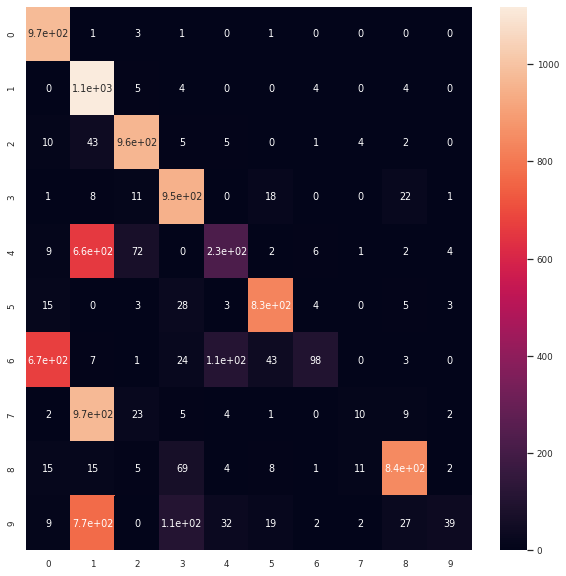

In [87]:
y,y_hat=conf_matrix(model=model,y_test=y_test)

## Let's see the actual pics the model got wrong

In [88]:
from matplotlib import pyplot as plt
def get_pics(test_val,pred_val,num_of_pics,y,y_hat):
  (x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()
  data = [x_test2[i] for i in range(len(y)) if y[i] == test_val and y_hat[i] == pred_val]
  for d in range(num_of_pics):
    plt.imshow(data[d], interpolation='nearest')
    plt.show()


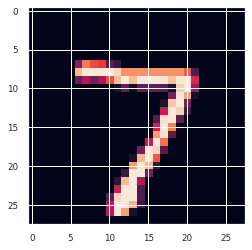

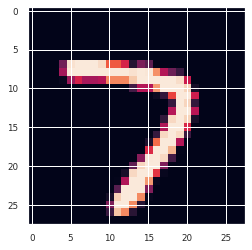

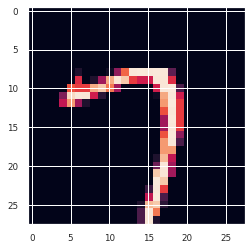

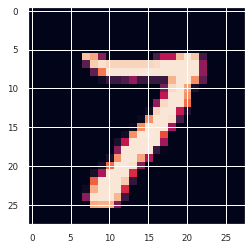

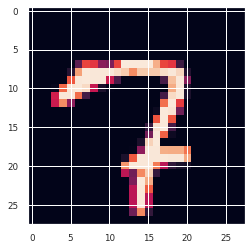

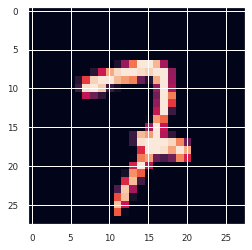

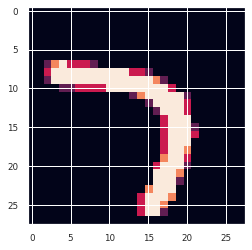

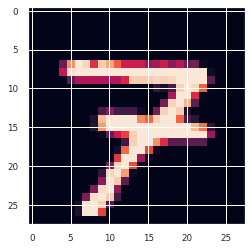

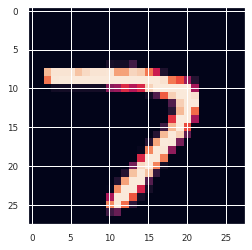

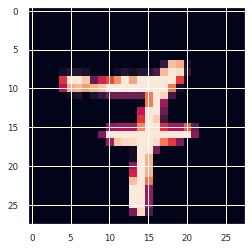

In [89]:
get_pics(7,1,10,y,y_hat)

## Fix it with more layers and neurons
### Note: it did better on some and worst on other

Epoch 1/30
540/540 [==============================] - 2s 4ms/step - loss: 1.7659 - accuracy: 0.3975 - val_loss: 1.1287 - val_accuracy: 0.6170
Epoch 2/30
540/540 [==============================] - 2s 3ms/step - loss: 0.6444 - accuracy: 0.8189 - val_loss: 0.2414 - val_accuracy: 0.9375
Epoch 3/30
540/540 [==============================] - 2s 3ms/step - loss: 0.2480 - accuracy: 0.9353 - val_loss: 0.1832 - val_accuracy: 0.9518
Epoch 4/30
540/540 [==============================] - 2s 3ms/step - loss: 0.1759 - accuracy: 0.9525 - val_loss: 0.1608 - val_accuracy: 0.9602
Epoch 5/30
540/540 [==============================] - 2s 3ms/step - loss: 0.1384 - accuracy: 0.9626 - val_loss: 0.1335 - val_accuracy: 0.9657
Epoch 6/30
540/540 [==============================] - 2s 3ms/step - loss: 0.1149 - accuracy: 0.9686 - val_loss: 0.1354 - val_accuracy: 0.9675
Epoch 6: early stopping
313/313 [==============================] - 1s 2ms/step
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall

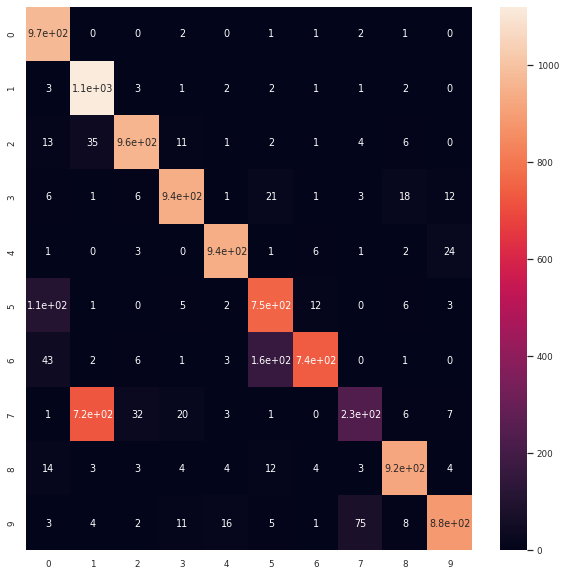

In [90]:
neurons = [(90,60,45,30,15)]
activations = [('relu','sigmoid')]
optimizer_adam = ['adam']
res = MyRandomSearchCV(neurons,activations,optimizer_adam,early_stop=True)[(neurons[0],activations[0],optimizer_adam[0])]
accuracy = res['accuracy']
model = res['model']
conf_matrix(model,y_test)
print(f"Time :\n {time.time() - T}")

## Traying the softmax activation function inested of sigmoid

Epoch 1/30
540/540 [==============================] - 2s 3ms/step - loss: 1.9152 - accuracy: 0.5385 - val_loss: 0.8678 - val_accuracy: 0.7450
Epoch 2/30
540/540 [==============================] - 2s 3ms/step - loss: 0.7767 - accuracy: 0.7709 - val_loss: 0.5799 - val_accuracy: 0.8372
Epoch 3/30
540/540 [==============================] - 2s 3ms/step - loss: 0.5603 - accuracy: 0.8462 - val_loss: 0.4576 - val_accuracy: 0.8870
Epoch 4/30
540/540 [==============================] - 2s 3ms/step - loss: 0.4225 - accuracy: 0.8915 - val_loss: 0.3300 - val_accuracy: 0.9170
Epoch 5/30
540/540 [==============================] - 2s 3ms/step - loss: 0.3366 - accuracy: 0.9155 - val_loss: 0.2991 - val_accuracy: 0.9338
Epoch 6/30
540/540 [==============================] - 2s 3ms/step - loss: 0.2786 - accuracy: 0.9294 - val_loss: 0.2491 - val_accuracy: 0.9472
Epoch 7/30
540/540 [==============================] - 2s 3ms/step - loss: 0.2437 - accuracy: 0.9372 - val_loss: 0.2304 - val_accuracy: 0.9445
Epoch 

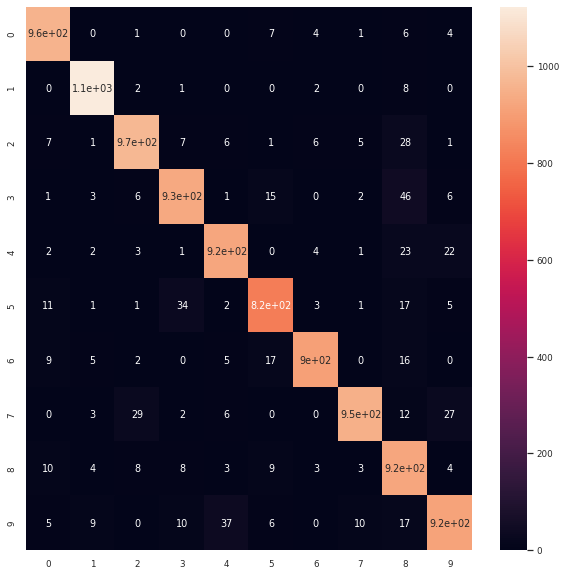

In [91]:
neurons=[(45,30,15)]
activations = [('relu','softmax')]
res = MyRandomSearchCV(neurons,activations,optimizer_adam,early_stop=True)[(neurons[0],activations[0],optimizer_adam[0])]
accuracy = res['accuracy']
model = res['model']
conf_matrix(model,y_test)
print(f"Time :\n {time.time() - T}")